# Data report for the efficacy dataset for unmodified siRNA (Ichihara)

In [1]:
from oligogym.data import DatasetDownloader
from oligogym.stats import get_cosine_dist_to_nearest_neighbor, get_outliers
from oligogym.features import KMersCounts
from oligogym.models import LinearModel
from oligogym.metrics import regression_metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Processed dataset

In [2]:
downloader = DatasetDownloader()
dataset_1 = downloader.download("siRNA1")
dataset_1.data.head()

,x,y,y_raw,targets,smiles,fasta
0,RNA1{r(A)p.r(A)p.r(A)p.r(U)p.r(C)p.r(A)p.r(A)p...,46.2,46.2,RHOQ,Cc1cn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)O[C@H]3C...,AAAUCAAUUAACAUAUUAG.CUAAUAUGUUAAUUGAUUUAU
1,RNA1{r(A)p.r(U)p.r(A)p.r(A)p.r(A)p.r(U)p.r(C)p...,38.4,38.4,RHOQ,Cc1cn([C@H]2C[C@H](OP(=O)(O)OC[C@H]3O[C@@H](n4...,AUAAAUCAAUUAACAUAUU.AAUAUGUUAAUUGAUUUAUAC
2,RNA1{r(G)p.r(A)p.r(A)p.r(A)p.r(G)p.r(G)p.r(A)p...,51.4,51.4,RHOQ,Cc1cn([C@H]2C[C@H](OP(=O)(O)OC[C@H]3O[C@@H](n4...,GAAAGGAAUUGUAUAAAUC.GAUUUAUACAAUUCCUUUCAA
3,RNA1{r(A)p.r(U)p.r(A)p.r(A)p.r(A)p.r(A)p.r(U)p...,36.4,36.4,RHOQ,Cc1cn([C@H]2C[C@H](O)[C@@H](COP(=O)(O)O[C@H]3C...,AUAAAAUUGAAAGGAAUUG.CAAUUCCUUUCAAUUUUAUCU
4,RNA1{r(C)p.r(U)p.r(U)p.r(A)p.r(U)p.r(U)p.r(U)p...,52.2,52.2,RHOQ,Cc1cn([C@H]2C[C@H](OP(=O)(O)OC[C@H]3O[C@@H](n4...,CUUAUUUAAUUUUGGUCUG.CAGACCAAAAUUAAAUAAGAA


In [3]:
dataset_2 = downloader.download("siRNA2")
dataset_2.data.head()

,x,y,y_raw,targets,smiles,fasta
0,RNA1{r(G)p.r(G)p.r(A)p.r(G)p.r(G)p.r(A)p.r(C)p...,83.0,83.0,LMNA,Nc1ccn([C@@H]2O[C@H](COP(=O)(O)O[C@H]3[C@@H](O...,GGAGGACCUGCAGGAGCUC.GAGCUCCUGCAGGUCCUCCUU
1,RNA1{r(G)p.r(G)p.r(A)p.r(C)p.r(C)p.r(U)p.r(G)p...,45.0,45.0,LMNA,Nc1ccn([C@@H]2O[C@H](COP(=O)(O)O[C@H]3[C@@H](O...,GGACCUGCAGGAGCUCAAU.AUUGAGCUCCUGCAGGUCCUC
2,RNA1{r(G)p.r(A)p.r(G)p.r(G)p.r(U)p.r(G)p.r(G)p...,80.0,80.0,LMNA,Nc1ccn([C@@H]2O[C@H](COP(=O)(O)O[C@H]3[C@@H](O...,GAGGUGGUCAGCCGCGAGG.CCUCGCGGCUGACCACCUCUU
3,RNA1{r(C)p.r(U)p.r(G)p.r(C)p.r(U)p.r(C)p.r(U)p...,88.0,88.0,LMNA,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](OP(=O)(O)OC[C@H...,CUGCUCUCAGUGAGAAGCG.CGCUUCUCACUGAGAGCAGUG
4,RNA1{r(C)p.r(U)p.r(G)p.r(G)p.r(A)p.r(C)p.r(U)p...,98.0,98.0,LMNA,Nc1ccn([C@@H]2O[C@H](CO)[C@@H](OP(=O)(O)OC[C@H...,CUGGACUUCCAGAAGAACA.UGUUCUUCUGGAAGUCCAGUU


## Features statistics

In [4]:
print(dataset_1.get_helm_stats().to_dict())

{'avg_nt_seq_len': {0: 21.0}, 'combined_unique_monomers': {0: ['A', 'C', 'G', 'T', 'U', 'd', 'p', 'r']}, 'avg_GC_content': {0: 47.7600830542007}, 'avg_G_content': {0: 23.895712131006245}, 'avg_C_content': {0: 35.812226988697574}, 'avg_A_content': {0: 23.66261189790601}, 'avg_TU_content': {0: 28.577305047893276}, 'num_duplicates': {0: 0}}


In [5]:
print(dataset_2.get_helm_stats().to_dict())

{'avg_nt_seq_len': {0: 19.0}, 'combined_unique_monomers': {0: ['A', 'C', 'G', 'U', 'p', 'r']}, 'avg_GC_content': {0: 48.91345308378344}, 'avg_G_content': {0: 24.45672654189172}, 'avg_C_content': {0: 36.68508981283758}, 'avg_A_content': {0: 25.543273458108274}, 'avg_TU_content': {0: 25.543273458108278}, 'num_duplicates': {0: 0}}


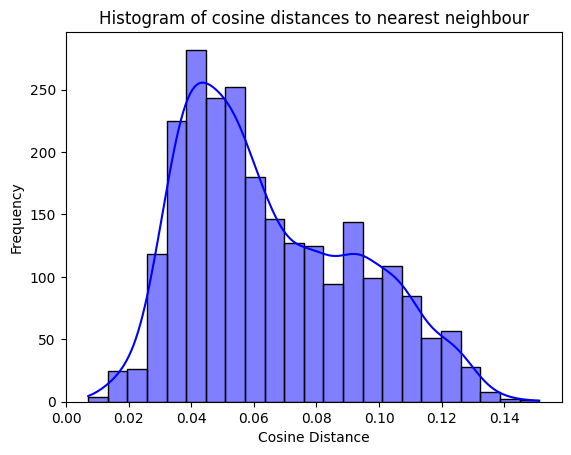

In [6]:
cosine_distances_1 = get_cosine_dist_to_nearest_neighbor(np.unique(dataset_1.x))

fig, ax = plt.subplots()

sns.histplot(cosine_distances_1, ax=ax, color='blue', kde=True)

ax.set_title('Histogram of cosine distances to nearest neighbour')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

plt.show()

In [7]:
number_similar_sequences = np.sum(cosine_distances_1 == 0)
print(f"{number_similar_sequences} ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count")

0 ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count


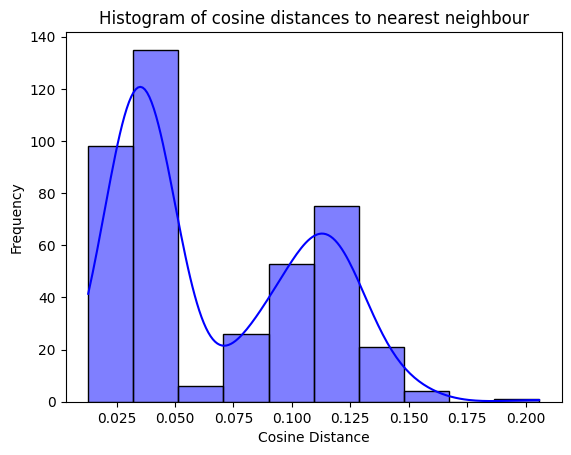

In [8]:
cosine_distances_2 = get_cosine_dist_to_nearest_neighbor(np.unique(dataset_2.x))

fig, ax = plt.subplots()

sns.histplot(cosine_distances_2, ax=ax, color='blue', kde=True)

ax.set_title('Histogram of cosine distances to nearest neighbour')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

plt.show()

In [9]:
number_similar_sequences = np.sum(cosine_distances_2 == 0)
print(f"{number_similar_sequences} ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count")

0 ASOs have cosine distance to NN of zero when measured using 1 to 5 mers frequency count


## Labels statistics

{'nobs': {0: 2431}, 'minmax': {0: (0.0, 134.1)}, 'mean': {0: 69.26869600987249}, 'variance': {0: 405.8988262412968}, 'skewness': {0: -0.07277231223541938}, 'kurtosis': {0: -0.1441581170083972}, 'num_zeros': {0: 1}}
9 datapoints are identified as outliers by IQR method


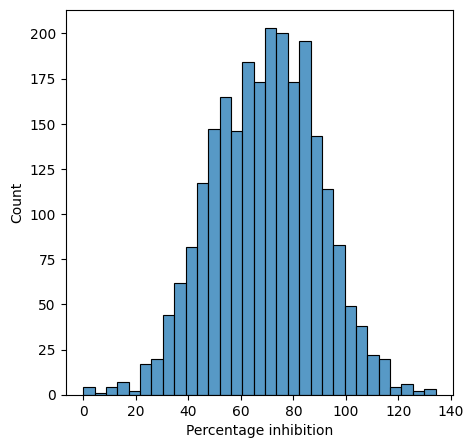

In [10]:
print(dataset_1.get_label_stats().to_dict())
print(f"{len(get_outliers(dataset_1.y))} datapoints are identified as outliers by IQR method")
fig,ax=plt.subplots(figsize=[5,5])

sns.histplot(x=dataset_1.y)
ax.set_xlabel('Percentage inhibition')
plt.show()

{'nobs': {0: 419}, 'minmax': {0: (-27.8, 98.9)}, 'mean': {0: 60.56810332912796}, 'variance': {0: 1036.6606813082026}, 'skewness': {0: -0.7211442184796778}, 'kurtosis': {0: -0.5923740826717077}, 'num_zeros': {0: 5}}
0 datapoints are identified as outliers by IQR method


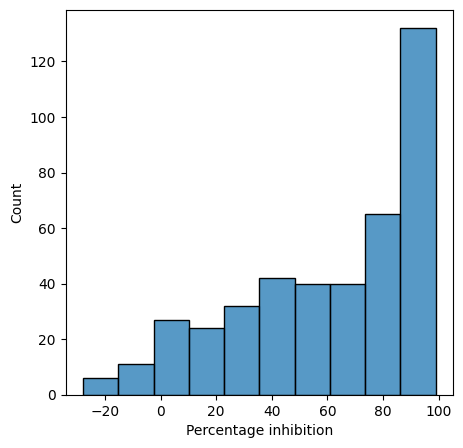

In [11]:
print(dataset_2.get_label_stats().to_dict())
print(f"{len(get_outliers(dataset_2.y))} datapoints are identified as outliers by IQR method")
fig,ax=plt.subplots(figsize=[5,5])

sns.histplot(x=dataset_2.y)
ax.set_xlabel('Percentage inhibition')
plt.show()

## Splitting analysis

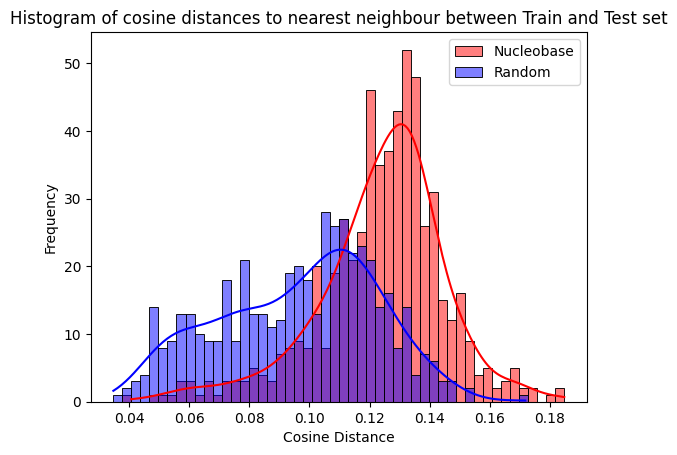

In [12]:
X_train, X_test, y_train, y_test = dataset_1.split(split_strategy="random", random_state=42)
cosine_dist_random = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

X_train, X_test, y_train, y_test = dataset_1.split(split_strategy="nucleobase", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

data_min = min(min(cosine_dist_random), min(cosine_dist_nucleobase))
data_max = max(max(cosine_dist_random), max(cosine_dist_nucleobase))

num_bins = 50
bin_edges = np.linspace(data_min, data_max, num_bins+1)

fig, ax = plt.subplots()

sns.histplot(cosine_dist_nucleobase, ax=ax, color='red', kde=True, label='Nucleobase', bins=bin_edges)
sns.histplot(cosine_dist_random, ax=ax, color='blue', kde=True, label='Random', bins=bin_edges)

ax.set_title('Histogram of cosine distances to nearest neighbour between Train and Test set')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

ax.legend()
plt.show()

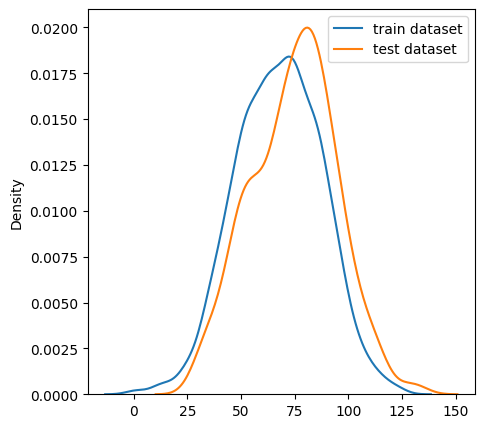

In [13]:
X_train, X_test, y_train, y_test = dataset_1.split(split_strategy="nucleobase", random_state=42)

fig,ax=plt.subplots(figsize=[5,5])

sns.kdeplot(ax=ax, x=y_train, label='train dataset')
sns.kdeplot(ax=ax, x=y_test, label='test dataset')
ax.legend()
plt.show()

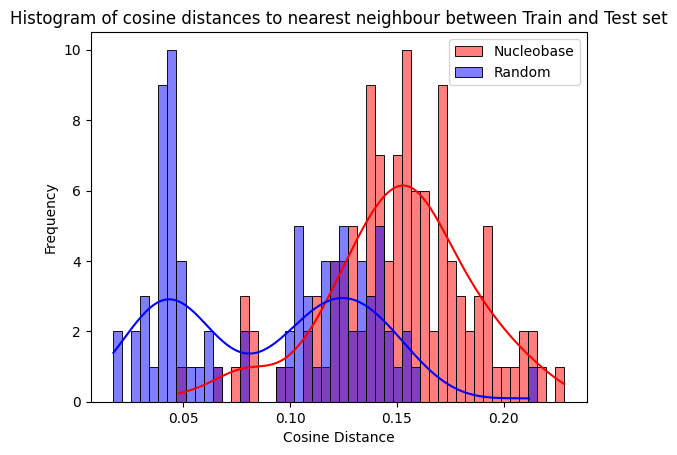

In [14]:
X_train, X_test, y_train, y_test = dataset_2.split(split_strategy="random", random_state=42)
cosine_dist_random = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

X_train, X_test, y_train, y_test = dataset_2.split(split_strategy="nucleobase", random_state=42)
cosine_dist_nucleobase = get_cosine_dist_to_nearest_neighbor(X_train, X_test)

data_min = min(min(cosine_dist_random), min(cosine_dist_nucleobase))
data_max = max(max(cosine_dist_random), max(cosine_dist_nucleobase))

num_bins = 50
bin_edges = np.linspace(data_min, data_max, num_bins+1)

fig, ax = plt.subplots()

sns.histplot(cosine_dist_nucleobase, ax=ax, color='red', kde=True, label='Nucleobase', bins=bin_edges)
sns.histplot(cosine_dist_random, ax=ax, color='blue', kde=True, label='Random', bins=bin_edges)

ax.set_title('Histogram of cosine distances to nearest neighbour between Train and Test set')
ax.set_xlabel('Cosine Distance')
ax.set_ylabel('Frequency')

ax.legend()
plt.show()

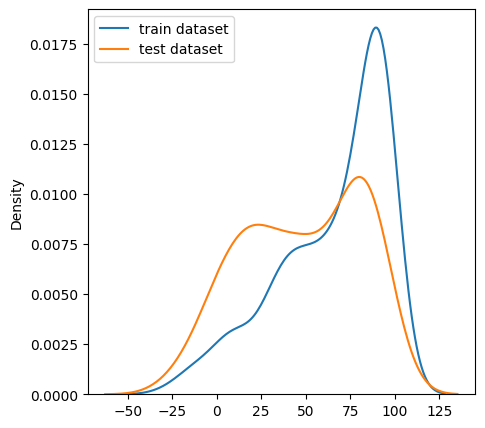

In [15]:
X_train, X_test, y_train, y_test = dataset_2.split(split_strategy="nucleobase", random_state=42)

fig,ax=plt.subplots(figsize=[5,5])

sns.kdeplot(ax=ax, x=y_train, label='train dataset')
sns.kdeplot(ax=ax, x=y_test, label='test dataset')
ax.legend()
plt.show()

## Predictability analysis

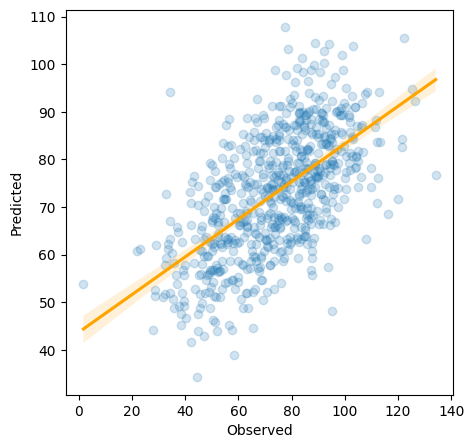

{'r2_score': 0.35470284749449377, 'root_mean_squared_error': 15.779640948145206, 'mean_absolute_error': 12.727827380952379, 'pearson_correlation': 0.6005561360335451, 'spearman_correlation': 0.604975003960746}


In [16]:
x_train,x_test,y_train,y_test = dataset_1.split('nucleobase')
feat=KMersCounts(k=[1,2,3], modification_abundance=False)
x_train=feat.fit_transform(x_train)
x_test=feat.transform(x_test)
model=LinearModel()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)

fig, ax = plt.subplots(figsize=[5,5])
sns.regplot(ax=ax,x=y_test,y=y_pred,scatter_kws={'alpha':0.2},line_kws={'color':'orange'})
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
plt.show()
print(regression_metrics(y_test,y_pred))

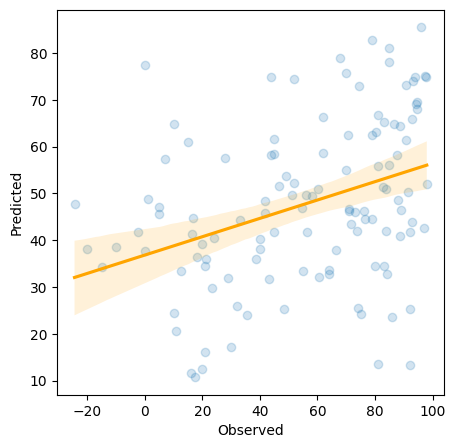

{'r2_score': 0.03582466117817995, 'root_mean_squared_error': 31.536743700408945, 'mean_absolute_error': 25.491186476644643, 'pearson_correlation': 0.3611179950819084, 'spearman_correlation': 0.3850037925140859}


In [17]:
x_train,x_test,y_train,y_test = dataset_2.split('nucleobase')
feat=KMersCounts(k=[1,2,3], modification_abundance=False)
x_train=feat.fit_transform(x_train)
x_test=feat.transform(x_test)
model=LinearModel()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)

fig, ax = plt.subplots(figsize=[5,5])
sns.regplot(ax=ax,x=y_test,y=y_pred,scatter_kws={'alpha':0.2},line_kws={'color':'orange'})
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
plt.show()
print(regression_metrics(y_test,y_pred))